<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_09_02_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Chap3. 분류**

### **1. MNIST**
---

#### **1) 사이킷런에서 제공하는 MNIST 데이터셋 다운받기**

In [ ]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR: 데이터셋 설명
- data: 샘플이 행, 특성이 열로 구성된 배열
- target: 레이블 배열

#### **2) 데이터 배열 살펴보기**

In [3]:
X,y = mnist['data'], mnist['target']
print(X.shape) 
print(y.shape) 
# 이미지 7만개, 특성이 784개 (이미지 28x28)

(70000, 784)
(70000,)


- 데이터셋에서 이미지 하나 확인해보기

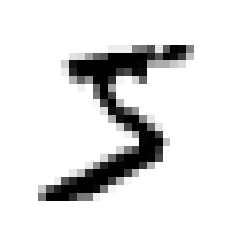

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0] # 원래 코드대로 하면 error 발생 why?
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [5]:
# y를 정수로 변환하기

y = y.astype(np.uint8)

In [6]:
# 학습/테스트 데이터셋 분리하기

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

### **2. 이진 분류기 훈련**
---

#### **1) 예를 들어 '5-감지기'는 5인 것과 5가 아닌 두 개의 클래스를 구분하는 이진 분류기**

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### **2) SGDClassifier로 확률적 경사 하강법 분류기 사용하기**
- 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지님
  - 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

- 따라서 SGD는 온라인 학습에 잘 들어맞음

In [8]:
from  sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

### **3. 성능 측정**
---

#### **1) 교차 검증을 사용한 정확도 측정**
- 교차 검증은 모델을 평가하는 좋은 방법
- cross_val_score()

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#for train_index, test_index in skfolds.split(X_train,y_train_5):
 # clone_clf = clone(sgd_clf)
  #X_train_folds = X_train[train_index]
  #y_train_folds = y_train_5[train_index]
  #X_test_fold = X_train[test_index]
  #y_test_fold = y_train_5[test_index]

  #clone_clf.fit(X_train_folds, y_train_folds)
  #y_pred = clone_clf.predict(X_test_fold)
  #n_correct = sum(y_pred == y_test_fold)
  #print(n_correct / len(y_pred))

KeyError: ignored

      1. StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함
      2. 분류기 객체를 복제하여(clone) 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
      3. 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함

- **폴드가 3개인 k-겹 교차 검증 사용해 SGDClassifier 모델 평가하기**

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

      1. 첫번째 결과는 정확도가 모두 95% 이상
      2. 두번째는 5가 아닌 것으로 예측하면 정답을 맞출 확률이 90% 이상
      3. 데이터셋이 심하게 불균등하면 정확도는 분류기의 성능 지표로 알맞지 않음

#### **2) 오차 행렬**
- 오차 행렬: 분류기 성능을 평가하는 좋은 지표
- a 샘플이 b 샘플로 분류된 횟수를 세는 것
- 실제 타깃값과 비교할 수 있게 먼저 예측값을 만들어야 함
- cross_val_predict() 사용하기

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

- cross_val_score()와의 차이점: 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

      1. 오차행렬의 행: 실제 클래스
      2. 오차행렬의 열: 예측 클래스
      3. 결과 종류
        - TN: 5가 아닌 것을 아님으로 정확히 분류
        - FP: 5가 아닌 것을 5로 분류
        - FN: 5인 것을 5가 아닌 것으로 분류
        - TP: 5인 것을 5로 정확히 분류

In [16]:
# 정확한 분류기일 경우 알아보기
y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 오차행렬보다 더 요약된 지표가 필요할 때: 정밀도, 재현율
- **정밀도**: 양성 예측의 정확도. but 다른 모든 양성 샘플을 무시하기 때문에 유용하진 않음
$$정밀도 = \frac{TP}{TP+FP}$$

- **재현율**: 정밀도와 같이 사용하는 지표(민감도)
$$재현율 = \frac{TP}{TP+FN}$$


#### **3) 정밀도와 재현율**

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


- 위 결과가 그리 좋지 않음 -> F1 score로 보완
- **F1 score**: 정확도와 재현율을 하나의 수로 합친 조화 평균
$$F1 = 2 \times \frac{정밀도\times재현율}{정밀도+재현율}$$

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

- 상황에 따라 정밀도와 재현율의 중요도가 다름
- 정밀도/재현율 트레이드오프: 정밀도를 올리면 재현율이 내려가고, 정밀도를 내리면 재현율이 올라감

#### **4) 정밀도/재현율 트레이드오프**

- SGDClassifier가 어떻게 분류를 결정하는지 살펴보기
- 결정 함수
  - 각 샘플의 점수를 계산함
  - 점수 > 임계값: 샘플은 양성 클래스에 할당됨
  - 점수 < 임계값: 샘플은 음성 클래스에 할당됨

- 사이킷런에서 임계값을 지정하진 못함
- 예측에 사용된 점수는 확인 가능함
- decision_function() 사용하기

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# 임계값 높여보기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 적절한 임계값을 구하기 위해 cross_val_predict()를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
- 예측 결과가 아닌 결정 점수를 반환받도록 지정해야함

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = 'decision_function')

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

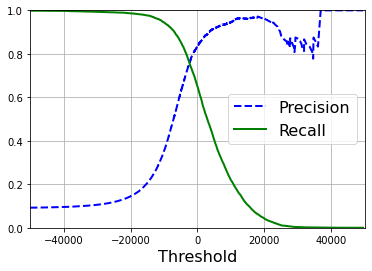

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) # 재현율

    # 그래프 설정
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1]) 

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [31]:
# np.argmax: 최대값의 첫번째 인덱스 반환 (첫번째 true 값)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [32]:
# 훈련 세트에 대한 정밀도가 90% 이상이 되도록 예측하기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90)) # 재현율 너무 낮음 -> 유용하지 x

0.9000345901072293
0.4799852425751706


#### **5) ROC 곡선**

- ROC 곡선: 이진 분류에서 널리 사용하는 지표
- 정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아닌, **거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)**의 곡선
 - **FPR**: **1 - TNR(진짜 음성 비율)**
 - **TNR**: **특이도(specificity)**
 - **민감도(재현율)에 대한 1-특이도 그래프**

- **roc_curve()** 함수를 이용해 여러 임계값에 대한 TPR과 FPR을 계산해야함

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])  

    plt.xlabel('거짓 양성 비율', fontsize=16) 
    plt.ylabel('진짜 양성 비율(재현율)', fontsize=16)
    plt.grid(True)

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# predict_proba : 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForest')
plt.legend(loc = 'lower right')

plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

### **4) 다중 분류**
---

- **다중 분류기(multiclass classifier)** 혹은 **다항 분류기(multinomial classifier)**은 둘 이상의 클래스를 구별 가능
- `SGDClassifier`, `RandomForestClassifier` 등 일부 알고리즘: 여러 개의 클래스를 직접 분류할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 등은 이진 분류만 가능
- 이진 분류기를 여러 개 사용-> 다중 클래스를 분류 가능
 - **OvR(혹은 OvA)** : 각 클래스 별 이진 분류기를 만들고, 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택하는 기법
 - **OvO** : 각 클래스 조합마다 이진 분류기를 훈련시키는 방법. 클래스가 N개라면, 분류기는 $N \times (N-1) /2$개 필요. 모든 분류기를 활용하여, 가장 많이 양성으로 분류된 클래스를 선택
 - 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감하여, 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO를 선호
 - 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호

- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택 -> 사이킷런이 알고리즘에 따라 자동으로 OvR 혹은 OvO를 실행함

In [ ]:
# 서포트 벡터 머신
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores 

In [ ]:
np.argmax(some_digit_scores) # 가장 높은 점수가 class 5

In [ ]:
svm_clf.classes_[5]

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### **5) 에러 분석**
---

- 실제 프로젝트라면 머신러닝 프로젝트 체크리스트의 단계를 따를 것이다.
  + 데이터 준비 단계에서 가능한 선택 사항을 탐색
  + 여러 모델을 시도
  + 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼 파라미터 튜닝
- 여기서는 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상시키는 방법을 찾아보도록 하자.
- 그 중 한 가지 방법이 에러의 종류를 분석하는 것이다.
- 먼저 오차 행렬을 살펴보자.
  + `cross_val_predict()` 함수를 사용해 예측을 만든다.
  + `confusion_matrix()`함수를 호출한다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# matplotlib을 사용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 숫자 그림을 위한 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

### **6) 다중 레이블 분류**
---

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

### **7) 다중 출력 분류**
---

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0

In [ ]:
# 숫자 이미지를 그리는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)